Importaremos los modulos que vamos a utilizar

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, preprocessing

import statsmodels.api as sm

Cargamos el csv

In [2]:
df = pd.read_csv('../Filtrado de datos/data_properatti_filtered.csv')

df.drop(columns='Unnamed: 0', inplace=True)

dict_names = {
    'place_with_parent_names' : 'ubicacion_completa',
    'state_name' : 'localidad',
    'place_name_imputado' : 'barrio',
    'property_type' : 'tipo_propiedad',
    'precio_usd_imputado' : 'precio',
    'precio_usd_por_m2_imputado' : 'precio_m2',
    'm2_totales_imputado' : 'm2_totales',
    'm2_cubiertos_imputado' : 'm2_cubiertos',
    'rooms_imputado' : 'ambientes'
    }

df.rename(columns= dict_names, inplace=True)
print(df.shape)
df.head()

(83489, 9)


ubicacion_completa  \
0              |Argentina|Capital Federal|Mataderos|   
1  |Argentina|Buenos Aires Costa Atlántica|Mar de...   
2               |Argentina|Capital Federal|Belgrano|   
3               |Argentina|Capital Federal|Belgrano|   
4  |Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...   

                      localidad     barrio tipo_propiedad    precio  \
0               Capital Federal  Mataderos      apartment   72000.0   
1  Buenos Aires Costa Atlántica     Centro      apartment   64000.0   
2               Capital Federal   Belgrano      apartment  138000.0   
3               Capital Federal   Belgrano      apartment  195000.0   
4      Bs.As. G.B.A. Zona Norte   Martínez      apartment  115000.0   

     precio_m2  m2_totales  m2_cubiertos  ambientes  
0  1309.090909        55.0          55.0        2.0  
1  1828.571429        35.0          35.0        1.0  
2  3066.666667        45.0          40.0        1.0  
3  3000.000000        65.0          60.0        2.0  
4  2948.717949        39.0          36.0        1.0

## Eleccion de los datos a modelar

Ya que debido a que debido a que hay una canitdad muy grande de elementos de distintas provincias, localidades y barrios, se nos dificultara la creacion de variables dummies para ese tipo de variable categorica, por lo tanto se adoptara las localidades mas representativas, eso quiere decir la que mayor cantidad de elementos tenga.

Para esto evaluaremos el dataframe, para poder seleccionar la misma.

In [3]:
df['localidad'].value_counts()

Capital Federal                 20490
Bs.As. G.B.A. Zona Norte        15367
Bs.As. G.B.A. Zona Sur          10424
Córdoba                          8914
Santa Fe                         7759
Bs.As. G.B.A. Zona Oeste         7657
Buenos Aires Costa Atlántica     7633
Buenos Aires Interior            1594
Neuquén                           472
Corrientes                        460
Tucumán                           451
Río Negro                         438
Mendoza                           426
Misiones                          309
Entre Ríos                        280
San Luis                          191
Chubut                            162
Salta                             151
La Pampa                          129
Formosa                            54
Chaco                              39
San Juan                           26
Tierra Del Fuego                   23
Santa Cruz                         14
Catamarca                          11
Jujuy                               9
Santiago Del

In [4]:
mask = df['localidad'] == 'Capital Federal'
print(len(df.loc[mask,'barrio'].unique()))
df.loc[mask,'barrio'].unique()

62


array(['Mataderos', 'Belgrano', 'Palermo Soho', 'Flores', 'Boedo',
       'Caballito', 'San Telmo', 'Almagro', 'Balvanera', 'Barrio Norte',
       'Villa Crespo', 'Nuñez', 'Constitución', 'Palermo Hollywood',
       'Saavedra', 'Parque Chas', 'Paternal', 'Agronomía', 'Coghlan',
       'Palermo', 'Monserrat', 'Villa Luro', 'Villa Devoto', 'Boca',
       'Barracas', 'Colegiales', 'San Cristobal', 'Villa Pueyrredón',
       'Abasto', 'Versalles', 'Monte Castro', 'Floresta', 'Retiro',
       'Capital Federal', 'Chacarita', 'Congreso', 'Recoleta',
       'Villa del Parque', 'Liniers', 'Centro / Microcentro',
       'Parque Centenario', 'Once', 'Villa Urquiza', 'Tribunales',
       'Velez Sarsfield', 'Catalinas', 'San Nicolás', 'Parque Chacabuco',
       'Las Cañitas', 'Parque Patricios', 'Parque Avellaneda',
       'Villa Santa Rita', 'Villa General Mitre', 'Palermo Viejo',
       'Villa Lugano', 'Villa Ortuzar', 'Villa Soldati', 'Puerto Madero',
       'Villa Real', 'Pompeya', 'Palermo Chi

Optaremos entonces por seleccionar a capital federal o CABA como nuestros datos a modelar, ya que es el que mayor cantidad de registros tiene y a la vez uno de los que menos elementos en la columna "barrios" tiene para discretizar.

In [5]:
df = pd.read_csv('../Filtrado de datos/data_properatti_filtered_capitalfederal.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.shape

(18241, 9)

## Correlaciones

Ahora procederemos a ver la correlacion entre las distintas variables.

Como se nos pide un modelo que prediga el precio por m2 de un inmueble, realizaremos varios graficos para ver como se comporta esa variable respecto a las demas.

<AxesSubplot:>

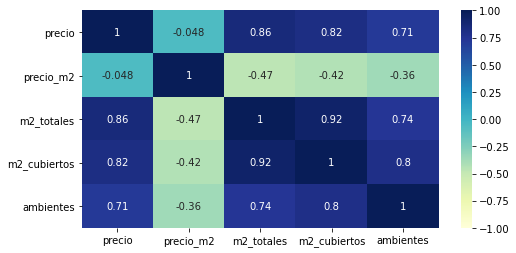

In [6]:
plt.figure(figsize=(8,4))

sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", center=0, vmin=-1, vmax=1)

In [7]:
fig = px.violin(df, x='tipo_propiedad', y='precio_m2')
fig.show()

fig = px.scatter(df, x='m2_totales', y='precio_m2', color = 'tipo_propiedad')
fig.show()

fig = px.scatter(df, x='m2_cubiertos', y='precio_m2', color = 'tipo_propiedad')
fig.show()

fig = px.violin(df, x='ambientes', y='precio_m2', color = 'tipo_propiedad')
fig.show()

De todos los graficos anteriores se puede observar que los datos tienen cierto sentido, y que este sentido esta ligado fuertemente al tipo de propiedad que se va a evaluar.

Puede apreciarse que a medida que los m2 crecen el precio por m2 tiende a disminuir, lo cual tiene sentido, por que el precio de un departamento por m2 es mas elevado que el precio por m2 de una casa, esta ultima generalmente suele tener mayor cantidad de m2 tanto totales como cubiertos.

Por lo tanto el tipo de porpiedad es una variable muy importante a la hora de predecir el valor del precio por m2.

#### Observaciones 

En el dataframe original podemos ver que precio no se correlaciona con precio por m2, esto no tendria sentido, pero luego vemos la distribucion de los datos y se puede observar que cada tipo de propiedad tiene una distribucion diferente una de la otra.

Esto nos da a entender que el echo de que este dando bajo el factor de correlacion entre el precio por m2 y el precio total, es por que a su vez hay una correlacion entre precio y m2 totales, pero no se estaria viendo la correlacion direca por que el factor de la superficie se esta llevando parte de la informacion que correlaciona al precio con la target.

## Variables dummies

Antes de aplicar algun modelo de regresion lineal debemos transformar las variables categoricas en variables dummies, nos interesa transformar:
- Los barrios, ya que creemos que la ubicacion de un inmueble es una variable clave a la hora de predecir el precio por m2 de una propiedad.
- El tipo de propiedad, ya que como vimos previamente, dependiendo del tipo de propiedad que se trate los datos se relacionan de distinta manera unos frente a otros.

Crearemos distintas variables dummies y luego crearemos un nuevo dataframe con todas nuestras features que incluiremos en nuestro modelo.

Otro aspecto a mencionar es que, cualitativamente tiene sentido que si uno quiere predecir el precio por m2 no habria que utilizar como variable predictoria el precio total ni los m2 totales, ya que la variable target (precio por m2) es combinacion de estas ultimas dos.

Esta ultima parte mencionada la verificaremos a la hora de aplicar statsmodel, veremos que pasa cuando incluimos los m2 y cuando no incluimos los mismos.

In [8]:
dummies_tipo_propiedad = pd.get_dummies(df['tipo_propiedad'], drop_first=True)
dummies_barrio = pd.get_dummies(df['barrio'], drop_first=True)

df_features = pd.concat([df[['m2_totales', 'm2_cubiertos', 'ambientes']], dummies_tipo_propiedad, dummies_barrio], axis=1)

## Modelos de regresion lineal

Primero haremos una funcion la cual me realice el train_test_split de los dataframes que le pase, esto lo haremos con el objetivo de tener un unico set de testeo y un unico set de train ya que si no hacemos esto nuestros datos iran variando cada vez que la funcion se ejecute.

In [9]:
def div_in_train_test_split (df_features, df_target, lasso_ridge_normalize = True):
    
    # Preparamos los datos en una matriz de features y otra de target.
    X = df_features
    y = df_target
    
    # separamos los datos en set de entrenamiento y set de testeo.
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.35, random_state=45)
    
    # Si el parametro lasso_ridge_normalize es False entonces regularizo mediante MinMax

    if lasso_ridge_normalize == False:
        scaler = preprocessing.MinMaxScaler()
                
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

Ahora crearemos una funcion que utilizaremos para nuestros modelos de regresion lineal (una regresion lineal sin regularizar, otro aplicandole Lasso y otro modelo aplicando Ridge).

Esta funcion toma como parametro dos dataframes (uno que corresponde a la variable target y otro que corresponde a los features), una lista de alphas que se le pasara a los distintos modelos de regularizacion y tres parametros que indican que modelos aplicar.

Dependiendo de que parametros le indiquemos como True o False, me devolvera distintas cosas.
- lin_reg, indica si aplicar unicamente regresion lineal.
- Lasso, indica si aplicar la regularizacion lasso
- Ridge, indica si aplicar la regularizacion Ridge
- lasso_ridge_normalize, indica si se le aplicara a mis datos la normalizacion que viene por defecto en ridge y lasso, en caso de que sea false se aplicara la normalizacion MinMax a mis datos de entrenamiento.
- coef_plot, indica si devuelve un grafico en el que se muestran todas las variables segun los distintos modelos de regularizacion.
- alpha_variation, si es True me devuelve un grafico en el que podremos ver la evolucion de los coeficientes alphas a medida que estos van aumentando su valor

Esta funcion a su vez me devuelve tres dataframes
- df_metricas, metricas de todos los modelos empleados
- df_alpha_variation, variables ordenadas, de manera ascendente, a medida que sus betas se van haciendo 0.
- df_coef, valores de los coeficientes de todas las variables indicando el modelo al cual pertenecen.

In [10]:
def linear_reg (X_train, X_test, y_train, y_test, list_alphas, lin_reg = False, Lasso = False, Ridge = False, lasso_ridge_normalize = True, coef_plot = False, alpha_variation = False):
    
    # primero creamos los df de salida.
    df_metricas = pd.DataFrame(columns = ['modelo', 'MAE', 'MSE', 'RMSE', 'R2_test', 'R2_train', 'alpha'])
    df_coef = pd.DataFrame(columns = ['variables', 'coeficientes', 'regularizacion'])
    
    # Creamos una lista con los distintos nombres de las variables
    list_columns = df_features.columns.tolist()
    list_columns.append('intercepto')
    
    if lin_reg == True:
        # instanciamos el modelo a utilizar.
        lr = linear_model.LinearRegression()
        
        # ajustamos o fiteamos el modelo a los datos de entrenamiento
        model_sin_regularizar = lr.fit(X_train, y_train)
        
        # predecimos etiquetas para los daos desconocidos.
        y_test_pred_sin_regularizar = model_sin_regularizar.predict(X_test)
        y_train_pred_sin_regularizar = model_sin_regularizar.predict(X_train)
        
        # Obtenemos las distintas metricas
        modelo = 'sin_reg'
        mae_lr = np.round(metrics.mean_absolute_error(y_test, y_test_pred_sin_regularizar),3)
        mse_lr = np.round(metrics.mean_squared_error(y_test, y_test_pred_sin_regularizar),3)
        rmse_lr = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_sin_regularizar)),3)
        r2_lr = np.round(metrics.r2_score(y_test, y_test_pred_sin_regularizar),3)
        r2_train_lr = np.round(metrics.r2_score(y_train, y_train_pred_sin_regularizar),3)
        alpha_lr = 0

        # Creamos una serie con todas las metricas evaluadas, y la adjuntamos al df creado al inicio de la funcion.
        value_serie = pd.Series([modelo, mae_lr, mse_lr, rmse_lr, r2_lr, r2_train_lr, alpha_lr], index=df_metricas.columns)
        df_metricas = df_metricas.append(value_serie, ignore_index=True)

        # Creamos una lista con los distintos valores de coeficiente de las distintas variables.
        list_coef = model_sin_regularizar.coef_.tolist()
        list_coef.append(model_sin_regularizar.intercept_)

        # Agregamos los valores a mi df de coeficientes
        for i in range(len(list_columns)):
            df_coef = df_coef.append({
                'variables' : list_columns[i],
                'coeficientes' : list_coef[i],
                'regularizacion' : 'sin_reg'
            },
            ignore_index=True
            )

    
    if Lasso == True:
        # instanciamos el modelo a utilizar
        lasso_lm = linear_model.LassoCV(alphas = list_alphas, normalize = lasso_ridge_normalize)
        
        # fiteamos el modelo a los datos de entrenamiento
        model_lasso = lasso_lm.fit(X_train, y_train)
        
        # predecimos etiquetas para los datos desconocidos
        y_test_pred_lasso = model_lasso.predict(X_test)
        y_train_pred_lasso = model_lasso.predict(X_train)
        
        # Obtenemos las distintas metricas
        modelo = 'Lasso'
        mae_lasso = np.round(metrics.mean_absolute_error(y_test, y_test_pred_lasso),3)
        mse_lasso = np.round(metrics.mean_squared_error(y_test, y_test_pred_lasso),3)
        rmse_lasso = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lasso)),3)
        r2_lasso = np.round(metrics.r2_score(y_test, y_test_pred_lasso),3)
        r2_train_lasso = np.round(metrics.r2_score(y_train, y_train_pred_lasso),3)
        alpha_lasso = model_lasso.alpha_
        
        # Creamos una serie con todas las metricas evaluadas, y la adjuntamos al df creado al inicio de la funcion.
        value_serie = pd.Series([modelo, mae_lasso, mse_lasso, rmse_lasso, r2_lasso, r2_train_lasso, alpha_lasso], index=df_metricas.columns)
        df_metricas = df_metricas.append(value_serie, ignore_index=True)

        # Creamos una lista con los distintos valores de coeficiente de las distintas variables.
        list_coef = model_lasso.coef_.tolist()
        list_coef.append(model_lasso.intercept_)

        # Agregamos los valores a mi df de coeficientes
        for i in range(len(list_columns)):
            df_coef = df_coef.append({
                'variables' : list_columns[i],
                'coeficientes' : list_coef[i],
                'regularizacion' : 'Lasso'
            },
            ignore_index=True
            )
            
    if Ridge == True:
        # instanciamos el modelo.
        ridge_lm = linear_model.RidgeCV(alphas = list_alphas, normalize = lasso_ridge_normalize)
        
        # fiteamos el modelo con los datos de entrnamiento.
        model_ridge = ridge_lm.fit(X_train, y_train)
        
        # predecimos etiquetas.
        y_test_pred_ridge = model_ridge.predict(X_test)
        y_train_pred_ridge = model_ridge.predict(X_train)
        
        # Obtenemos las distintas metricas
        modelo = 'Ridge'
        mae_ridge = np.round(metrics.mean_absolute_error(y_test, y_test_pred_ridge),3)
        mse_ridge = np.round(metrics.mean_squared_error(y_test, y_test_pred_ridge),3)
        rmse_ridge = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_ridge)),3)
        r2_ridge = np.round(metrics.r2_score(y_test, y_test_pred_ridge),3)
        r2_train_ridge = np.round(metrics.r2_score(y_train, y_train_pred_ridge),3)
        alpha_ridge = model_ridge.alpha_
        
        # Creamos una serie con todas las metricas evaluadas, y la adjuntamos al df creado al inicio de la funcion.
        value_serie = pd.Series([modelo, mae_ridge, mse_ridge, rmse_ridge, r2_ridge, r2_train_ridge, alpha_ridge], index=df_metricas.columns)
        df_metricas = df_metricas.append(value_serie, ignore_index=True)
        
        # Creamos una lista con los distintos valores de coeficiente de las distintas variables.
        list_coef = model_ridge.coef_.tolist()
        list_coef.append(model_ridge.intercept_)

        # Agregamos los valores a mi df de coeficientes
        for i in range(len(list_columns)):
            df_coef = df_coef.append({
                'variables' : list_columns[i],
                'coeficientes' : list_coef[i],
                'regularizacion' : 'Ridge'
            },
            ignore_index=True
            )
    
    if coef_plot == True:
        
        fig_coef = px.scatter(df_coef, x = 'coeficientes', y = 'variables', color='regularizacion', log_x=True, title='Valor de los coeficientes para los distintos modelos', height = 1000)
        fig_coef.show()
    
    if alpha_variation == True:
        # creamos df del cual plotearemos
        df_plot = pd.DataFrame(columns = ['variables', 'coeficientes', 'alpha'])
        # Creamos una lista con el nombre de las variables.
        list_columns = df_features.columns.tolist()
        
        for i in list_alphas:
            lasso_lm = linear_model.Lasso(alpha=i, normalize = lasso_ridge_normalize)
        
            model_lasso = lasso_lm.fit(X_train, y_train)
        
            list_coef = model_lasso.coef_.tolist()
        
            for j in range(len(list_columns)):
                df_plot = df_plot.append({
                    'variables' : list_columns[j],
                    'coeficientes' : list_coef[j],
                    'alpha' : i
                },
                ignore_index=True
                )
        
        mask_coef_0 = df_plot['coeficientes'] == 0
        df_coef_nulos = df_plot[mask_coef_0]      
        df_alpha_variation = pd.DataFrame(df_coef_nulos.groupby('variables')['alpha'].min().sort_values(ascending=True))
        
        fig = px.line(df_plot, x="alpha", y="coeficientes", color='variables', log_x=True,title='Variacion los coeficientes segun alpha', height=1000)
        fig.show()

        return df_alpha_variation
    
    return df_metricas, df_coef

Crearemos una funcion de statsmodel para poder evaluar el nivel de significancia de las variables, de esa manera podremos evaluar que variables son significativas para mi modelo de prediccion, al fin de saber que variable utilizar para que mi modelo prediga de manera correcta.

Esta funcion me devuelve el resumen de stats model y a la vez una lista con el nombre de las variables cuyo valor es mayor que mi nivel de significancia.

In [11]:
def stats_model (df_features, df_target, nivel_significancia = 0.05):
    X = df_features
    y = df_target
    
    # Tenemos que agregar explícitamente a una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    
    resumen = model.summary()

    # La tabla que obtengo es un objeto lista. La tabla en el indice [1] corresponde a la tabla que me interesa del resumen
    resumen_html = resumen.tables[1].as_html()
    
    # El metodo read_html pone a los DFs en una lista, por lo tanto queremos obtener el indice [0]
    df_resumen = pd.read_html(resumen_html, header=0, index_col=0)[0]
    
    mask_nivel_siginifica = (df_resumen['P>|t|'] > nivel_significancia) & (df_resumen['P>|t|'] < (1 - nivel_significancia))
    variables_no_significativas = df_resumen.loc[mask_nivel_siginifica,:].index.tolist()
    
    return resumen, variables_no_significativas

## Modelo de prediccion del precio por m2

### Modelo 1 - Sin normalizacion previa

En principio tendremos que ver el nivel de significancia de las distintas variables, por lo tanto utilizaremos la funcion de stats model para evaluar los distintos P values.

Adoptaremos un nivel de significancia de 0.05, por lo tanto si tengo un valor mayor a ese no podre rechazar H0, esto implica que no podemos afirmar que B1 sea mayor que 0.

In [12]:
resumen, no_significativas = stats_model(df_features, df['precio_m2'])
print(resumen)

                            OLS Regression Results                            
Dep. Variable:              precio_m2   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     369.5
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:07:47   Log-Likelihood:            -1.3416e+05
No. Observations:               18241   AIC:                         2.684e+05
Df Residuals:                   18185   BIC:                         2.689e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1957.3612 

Aqui se puede observar que hay un problema de multicolinealidad como habiamos predicho, no podemos predecir el precio por m2 utilizando las variables de los m2 totales y los m2 cubiertos, ya que la variable target es combinacion de las mismas, por lo tanto debemos dropear las columnas de los m2.

In [13]:
df_features.drop(columns=['m2_totales', 'm2_cubiertos'], inplace=True)

In [14]:
X_train, X_test, y_train, y_test = div_in_train_test_split(df_features, df['precio_m2'])

In [15]:
alphas = np.logspace(-2,2, 500)
df_metricas, df_coef_las_rid_norm = linear_reg(X_train, X_test, y_train, y_test, alphas, lin_reg = True, Lasso = True, Ridge = True, coef_plot = True)
df_metricas

modelo      MAE         MSE     RMSE  R2_test  R2_train alpha
0  sin_reg  301.696  151054.284  388.657    0.510     0.509     0
1    Lasso  301.963  151247.236  388.905    0.509     0.509  0.01
2    Ridge  301.900  151154.004  388.785    0.509     0.509  0.01

Comparando este modelo sin considerar la variable m2 totales y cubiertos, con el anterior, vemos que el valor de R2 es menor, pero eso no nos importa ya que es preferible tener un R2 menos que un problema de multicolinealidad. Ya que la multicolinealidad me aumenta la varianza del estimador.

Ahora procederemos a realizar una comparativa entre Lasso y entre stats model, veremos que variables son las primeras en que sus coeficientes sean 0, y las compararemos con las variables que no logran rechazar H0, primero graficaremos la variacion de los coeficientes a medida que alpha aumenta su valor.

In [16]:
df_coef_lasso = linear_reg(X_train, X_test, y_train, y_test, alphas, alpha_variation=True)

In [17]:
resumen, no_significativas = stats_model(df_features, df['precio_m2'])

print('Variables no significativas', no_significativas, '\n')
print(resumen)

Variables no significativas ['Almagro', 'Centro / Microcentro', 'Chacarita', 'Monserrat', 'Monte Castro', 'Parque Chas', 'Paternal', 'Puerto Madero', 'Saavedra', 'San Nicolás', 'San Telmo', 'Versalles', 'Villa Devoto', 'Villa General Mitre', 'Villa Luro', 'Villa Ortuzar', 'Villa Real', 'Villa Santa Rita', 'Villa del Parque'] 

                            OLS Regression Results                            
Dep. Variable:              precio_m2   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     357.0
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:08:45   Log-Likelihood:            -1.3450e+05
No. Observations:               18241   AIC:                         2.691e+05
Df Residuals:                   18187   BIC:                         2.695e+05
Df Model:                          53  

Aqui podremos observar que hay varias variable cuyo p value es mayor que mi nivel de significancia, ademas hay un problema de multicolinealidad.

Para el caso de las variables con un P value mayor que mi nivel de sigificancia las dropearemos.

In [18]:
df_features.drop(columns=no_significativas, inplace=True)

resumen, no_significativas_2 = stats_model(df_features, df['precio_m2'])

print('Variables no significativas nuevas', no_significativas_2)

no_significativas.append(no_significativas_2)

Variables no significativas nuevas ['Villa Pueyrredón']


Ahora veremos si mis variables no significativas son similares a mis variables cuyos coeficientes se hacen 0 rapidamente.

In [19]:
df_comparasion = df_coef_lasso.iloc[0:len(no_significativas),:]

mask_comparasion = df_comparasion.index.isin(no_significativas)

porcentaje_variables_iguales = np.round(len(df_comparasion[mask_comparasion].index) / len(no_significativas),2)
print('Porcentaje de variables no significativas - lasso contra statsmodel', porcentaje_variables_iguales, '\n')
print('Data Frame que muestra variacion de coeficientes a medida que aumenta alpha')
df_comparasion

Porcentaje de variables no significativas - lasso contra statsmodel 0.8 

Data Frame que muestra variacion de coeficientes a medida que aumenta alpha


alpha
variables                     
Almagro               0.010000
Parque Chas           0.010000
San Nicolás           0.010000
Puerto Madero         0.010000
Villa Pueyrredón      0.010000
Centro / Microcentro  0.010376
Villa Devoto          0.025165
Villa Santa Rita      0.031990
Chacarita             0.033193
Villa Ortuzar         0.038474
Villa Real            0.039191
Villa General Mitre   0.040665
Villa del Parque      0.044596
Versalles             0.051692
Villa Riachuelo       0.058822
Villa Soldati         0.073406
Monserrat             0.076166
Velez Sarsfield       0.079031
Paternal              0.095051
Monte Castro          0.106182

Se puede ver entonces que al aplicar lasso los primeros coeficiente que se van haciendo 0 corresponden a un gran porcentaje de variables no significativas (80%) segun el modelo de Statsmodel.

Ahora procederemos a dropear las variables no significativas y veremos como eso modifico a mi modelo.

In [20]:
df_features.drop(columns=no_significativas_2, inplace=True)

resumen, no_significativas = stats_model(df_features, df['precio_m2'])

print('Variables no significativas', no_significativas, '\n')
print(resumen)

Variables no significativas [] 

                            OLS Regression Results                            
Dep. Variable:              precio_m2   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     562.8
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:08:46   Log-Likelihood:            -1.3459e+05
No. Observations:               18241   AIC:                         2.693e+05
Df Residuals:                   18207   BIC:                         2.695e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

Procederemos a ver como varian los valores de alphas adoptados a medida que este aumenta su valor.

Esto nos dara un indicio de que variables son las mas confiables a la hora de predecir.

In [21]:
# Volvemos a splitear nuestro nuevo df_features sin variables no significativas.
X_train, X_test, y_train, y_test = div_in_train_test_split(df_features, df['precio_m2'], lasso_ridge_normalize=True)

linear_reg(X_train, X_test, y_train, y_test, alphas, alpha_variation=True)

alpha
variables                  
Villa Riachuelo    0.061034
Villa Soldati      0.076166
Velez Sarsfield    0.083530
Parque Chacabuco   0.125371
Parque Avellaneda  0.134977
Retiro             0.162338
Pompeya            0.162338
Coghlan            0.239198
Barracas           0.248193
Colegiales         0.257526
Balvanera          0.282424
San Cristobal      0.304065
Caballito          0.327363
Villa Lugano       0.346002
Liniers            0.359013
Constitución       0.359013
Mataderos          0.365701
Parque Patricios   0.386522
Flores             0.423891
Villa Urquiza      0.431788
Villa Crespo       0.448025
Boca               0.456372
Nuñez              0.473533
Floresta           0.482355
store              0.548882
Barrio Norte       0.590940
Boedo              0.590940
Recoleta           0.613162
Belgrano           1.282970
Palermo            1.282970
ambientes          1.331216
house              1.514819
apartment          2.273597

In [22]:
df_metricas, df_coef = linear_reg(X_train, X_test, y_train, y_test, alphas, lin_reg = True, Lasso = True, Ridge = True, coef_plot = True)
df_metricas

modelo      MAE         MSE     RMSE  R2_test  R2_train alpha
0  sin_reg  303.676  152849.343  390.960    0.504     0.505     0
1    Lasso  303.853  152946.004  391.083    0.503     0.505  0.01
2    Ridge  303.908  152917.425  391.047    0.503     0.505  0.01

Puede verse que al eliminar las variables en las que no pudimos rechazar H0, mis valores de r2 se vieron muy levemente disminuidos.

En cuanto a las metricas estas aumentaron levemente tambien, por lo que en ese sentido seria mejor el echo de considerar la totalidad de las variables.

El valor de los alphas se manuto igual.

Otra cosa muy distintiva que se puede apreciar de los graficos, al eliminar esas variables, mis coeficientes entre los distintos modelos se agruparon y tuvieron una diferencia menor entre los modelos de regularizacion.

Por lo tanto podemos decir que el hecho de dropear las variables no significativas, cambia los valores de mis coeficientes del modelo sin regularizar. Haciendo que estos se asemejen a los valores de los modelos regularizados.

Por lo tanto regularizar el modelo ayuda con las variables no significativas reduciendo su coeficiente (0 en el caso de Lasso y proximo a 0 en caso de Ridge). Por eso cuando no dropeamos las variables no significativas, como al principio, se nota la diferencia entre los coeficientes de los distintos modelos.

Por lo tanto el no considerar las variables no significativas no me trajo ningun beneficio al modelo, ya que podria considerar todas las variables y aplicar algun modelo de regularizacion y de manera "automatica" mis variables no significativas irian perdiendo relevancia.

### Modelo 2 - con normalizacion previa

Creemos que no deberia cambiar mucho nuestro modelo ya que solo estariamos normalizando la varaiable ambientes, ya que los m2 me producen un problema de multicolinealidad entonces estas variables no se tendran en cuenta.

Ahora procederemos a hacer lo mismo que antes, solo que normalizaremos todas las variables numericas para ver si esto ayuda a obtener un mejor valor de R2.

In [23]:
df_features = pd.concat([df['ambientes'], dummies_tipo_propiedad, dummies_barrio], axis=1)
X_train, X_test, y_train, y_test = div_in_train_test_split(df_features, df['precio_m2'], lasso_ridge_normalize=False)

In [24]:
df_metricas, df_coef = linear_reg(X_train, X_test, y_train, y_test, alphas, lin_reg = True, Lasso = True, Ridge = True, lasso_ridge_normalize = False, coef_plot = True)
df_metricas

modelo      MAE         MSE     RMSE  R2_test  R2_train      alpha
0  sin_reg  301.696  151054.284  388.657    0.510     0.509          0
1    Lasso  301.965  151298.702  388.971    0.509     0.509  0.0850863
2    Ridge  301.905  151164.347  388.799    0.509     0.509    3.22863

Puede verse que los coeficientes de las variables entre los distintos modelos tienden a estar mas alejados entre si, ya que los valores de los coeficientes regularizados son mas grandes.

Los valores de R2 y las metricas son iguales a el modelo 1.

Los alphas adoptados por el modelo aumentaron su valor, en ridge se puede ver un aumento significativo mientras que en Lasso fue un aumento pequeno.

In [25]:
df_coef_lasso = linear_reg(X_train, X_test, y_train, y_test, alphas, alpha_variation=True, lasso_ridge_normalize=False)

Puede verse que al considerar todas las variables, los valores de alpha tambien aumentaron su valor considerablemente, veremos ahora si cambio el orden en que estas variables se van haciendo 0 y si se corresponden nuevamente con las variables que son mayores que mi nivel de significancia.

In [26]:
resumen, no_significativas = stats_model(df_features, df['precio_m2'])

print('Variables no significativas', no_significativas, '\n')
print(resumen)

Variables no significativas ['Almagro', 'Centro / Microcentro', 'Chacarita', 'Monserrat', 'Monte Castro', 'Parque Chas', 'Paternal', 'Puerto Madero', 'Saavedra', 'San Nicolás', 'San Telmo', 'Versalles', 'Villa Devoto', 'Villa General Mitre', 'Villa Luro', 'Villa Ortuzar', 'Villa Real', 'Villa Santa Rita', 'Villa del Parque'] 

                            OLS Regression Results                            
Dep. Variable:              precio_m2   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     357.0
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:12:21   Log-Likelihood:            -1.3450e+05
No. Observations:               18241   AIC:                         2.691e+05
Df Residuals:                   18187   BIC:                         2.695e+05
Df Model:                          53  

Aqui no cambio nada, las mismas variables siguen siendo no significativas.

Ahora veremos el caso de si los primeros coeficientes de lasso que se hacen 0 coinciden en cierta manera con mis variables no siginificativas.

In [27]:
df_features.drop(columns=no_significativas, inplace=True)

resumen, no_significativas_2 = stats_model(df_features, df['precio_m2'])

print('Variables no significativas nuevas', no_significativas_2)

no_significativas.append(no_significativas_2)

Variables no significativas nuevas ['Villa Pueyrredón']


In [28]:
df_comparasion = df_coef_lasso.iloc[0:len(no_significativas),:]

mask_comparasion = df_comparasion.index.isin(no_significativas)

porcentaje_variables_iguales = np.round(len(df_comparasion[mask_comparasion].index) / len(no_significativas),2)
print('Porcentaje de variables no significativas - lasso contra statsmodel', porcentaje_variables_iguales, '\n')
print('Data Frame que muestra variacion de coeficientes a medida que aumenta alpha')
df_comparasion

Porcentaje de variables no significativas - lasso contra statsmodel 0.75 

Data Frame que muestra variacion de coeficientes a medida que aumenta alpha


alpha
variables                     
Puerto Madero         0.010000
Villa Pueyrredón      0.010000
San Nicolás           0.011379
Parque Chas           0.015573
Villa Devoto          0.021314
Chacarita             0.035736
Villa Santa Rita      0.065711
Monserrat             0.079031
Villa Real            0.082003
Villa General Mitre   0.089931
Villa Riachuelo       0.110175
Versalles             0.140053
Villa Soldati         0.159369
Velez Sarsfield       0.248193
Villa Ortuzar         0.439832
Centro / Microcentro  0.456372
Monte Castro          0.456372
Paternal              0.473533
Parque Avellaneda     0.519315
Villa Luro            0.569523

Observamos que aqui bajo el porcentaje de variables que se relacionan entre lasso y statsmodel.

Ya que los alphas aumentaron notablemente, se requirieron alphas mas grandes para que el coeficiente de la variable se haga 0.

In [29]:
df_features.drop(columns=no_significativas_2, inplace=True)

resumen, no_significativas = stats_model(df_features, df['precio_m2'])

print('Variables no significativas', no_significativas, '\n')
print(resumen)

Variables no significativas [] 

                            OLS Regression Results                            
Dep. Variable:              precio_m2   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     562.8
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        02:12:21   Log-Likelihood:            -1.3459e+05
No. Observations:               18241   AIC:                         2.693e+05
Df Residuals:                   18207   BIC:                         2.695e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

In [30]:
# Volvemos a splitear nuestro neuvo df_features
X_train, X_test, y_train, y_test = div_in_train_test_split(df_features, df['precio_m2'], lasso_ridge_normalize=False)

linear_reg(X_train, X_test, y_train, y_test, alphas, alpha_variation=True, lasso_ridge_normalize=False)

alpha
variables                   
Villa Riachuelo     0.130085
Villa Soldati       0.188169
Velez Sarsfield     0.321376
Parque Avellaneda   0.613162
Pompeya             0.684970
Parque Chacabuco    0.793962
Retiro              1.381276
Villa Lugano        2.493409
Barracas            2.539859
Coghlan             2.998844
Constitución        3.350041
Mataderos           3.476019
Colegiales          3.606735
Liniers             3.742366
Balvanera           3.812083
Boca                4.029122
Parque Patricios    4.180637
San Cristobal       4.180637
Floresta            6.391624
Nuñez               7.687260
Caballito           9.245531
Barrio Norte        9.953962
Recoleta           10.139395
Flores             10.328281
Villa Urquiza      11.326826
Villa Crespo       11.326826
Boedo              12.421910
store              14.135156
ambientes          20.827506
house              22.841122
Belgrano           36.234163
Palermo            40.477570
apartment          86.272373

In [31]:
df_metricas, df_coef = linear_reg(X_train, X_test, y_train, y_test, alphas, lin_reg = True, Lasso = True, Ridge = True, lasso_ridge_normalize = False, coef_plot = True)
df_metricas

modelo      MAE         MSE     RMSE  R2_test  R2_train    alpha
0  sin_reg  303.676  152849.343  390.960    0.504     0.505        0
1    Lasso  303.689  152863.342  390.977    0.504     0.505     0.01
2    Ridge  303.768  152917.613  391.047    0.503     0.505  1.63089

Comparando este modelo sin variables significativas con mi modelo 1, podemos ver que no hubo ningun cambio en cuanto a las metricas. El unico cambio apreciable se da en el alpha el de lasso el cual aumento bastante

Como el caso anterior el no considerar las variables no significativas no me trajo nigun beneficio al modelo en todo caso me lo empeoro.

En el grafico podemos observar que los coeficientes de las variables se agruparon todavia mas que el modelo 1, esto quiere decir que hay poca diferencia entre los modelos regularizados y el sin regularizar una vez que se dropearon las variables no significativas.

Lo dicho previamente afirma lo que dijimos al final del modelo 1, regularizar el modelo ayuda con mis variables no significativas, compensando los coeficientes de mis variables significativas haciendo que mi modelo sin regularizacion se asemeje a mi modelo regularizado.

Podemos decir que normalizar un modelo previo a su regularizacion no me cambia en nada.

En cuanto a Lasso al no normalizar los modelos de regularizacion tienden a buscar el menor alpha, mientras que si normalizamos antes de aplicar la regularizacion el alpha tiende a aumentar.

### Modelo 3 - Elevando la variable ambiente a distintas potencias

Veremos que pasa con el modelo al elevar la variable mencionada a distintas potencias, compararemos los distintos R2 test y R2 train.

Consideramos que esta feature es una variable muy importante por lo tanto aumentarmos su potencia para ver si eso mejora mi modelo de prediccion.

En primera instancia no dropearemos las variables no significativas.

In [32]:
df_features = pd.concat([dummies_tipo_propiedad, dummies_barrio], axis=1)

In [33]:
df_comparasion_r2 = pd.DataFrame(columns=['potencia','R2_test', 'R2_train', 'modelo', 'alpha'])

df_func = pd.concat([df['ambientes'], df_features], axis=1)

X_train, X_test, y_train, y_test = div_in_train_test_split(df_func, df['precio_m2'], lasso_ridge_normalize=True)

df_metricas, df_coef = linear_reg(X_train, X_test, y_train, y_test, alphas, lin_reg = True, Lasso = True, Ridge = True)

df_metricas['potencia'] = 1

df_comparasion_r2 = pd.concat([df_comparasion_r2, df_metricas[['potencia', 'R2_test', 'R2_train', 'modelo', 'alpha']]], axis=0)

In [34]:
df_potencia = pd.DataFrame(data=df['ambientes'])
df_potencia.rename(columns={'ambientes' : 'ambientes^1'}, inplace=True)

potencia = [i for i in range(1,10,2)]

for i in potencia:
    df_potencia['ambientes^'+str(i)] = df['ambientes'] ** i
    
for i in potencia:
    df_func = pd.concat([df_potencia['ambientes^'+str(i)], df_features], axis=1)
    
    X_train, X_test, y_train, y_test = div_in_train_test_split(df_func, df['precio_m2'], lasso_ridge_normalize=True)
    
    df_metricas, df_coef = linear_reg(X_train, X_test, y_train, y_test, alphas, lin_reg = True, Lasso = True, Ridge = True)
    
    df_metricas['potencia'] = str(i)
    
    df_comparasion_r2 = pd.concat([df_comparasion_r2, df_metricas[['potencia', 'R2_test', 'R2_train', 'modelo', 'alpha']]], axis=0)
    
    df_func.drop(columns='ambientes^'+str(i))
    
df_comparasion_r2.reset_index(inplace=True)
df_comparasion_r2.drop(columns='index', inplace=True)
df_comparasion_r2

potencia  R2_test  R2_train   modelo alpha
0         1    0.510     0.509  sin_reg     0
1         1    0.509     0.509    Lasso  0.01
2         1    0.509     0.509    Ridge  0.01
3         1    0.510     0.509  sin_reg     0
4         1    0.509     0.509    Lasso  0.01
5         1    0.509     0.509    Ridge  0.01
6         3    0.509     0.508  sin_reg     0
7         3    0.509     0.508    Lasso  0.01
8         3    0.509     0.508    Ridge  0.01
9         5    0.507     0.505  sin_reg     0
10        5    0.506     0.505    Lasso  0.01
11        5    0.507     0.505    Ridge  0.01
12        7    0.506     0.504  sin_reg     0
13        7    0.505     0.504    Lasso  0.01
14        7    0.506     0.504    Ridge  0.01
15        9    0.506     0.504  sin_reg     0
16        9    0.505     0.504    Lasso  0.01
17        9    0.505     0.504    Ridge  0.01

Se puede ver que aumentar la potencia de mi variable ambientes no produce un cambio alguno, para que la potencia de la variable impacte en mi modelo su valor debe ser elevado, esto es en el caso de mi modelo sin regularizar.

Por lo tanto elevar la potencia de mi variable no me ayuda en nada.

## Conclusiones

Aplicamos distintas modificaciones a mis parametros con el objetivo de mejorar la performance del modelo, pero ninguna nos dio resultados positivos en cuanto a la mejora del modelo predictivo.

En principio, separamos mis variables en distintos data frames, según tipo de propiedad, conjeturando que aquello pudiera llegar a contribuir a aislar mejor las correlaciones lineales entre nuestras features y la variable a predecir. El hecho es que la separación del dataframe en partes empeoró las métricas. Creemos que lo que ocurrió es que hubo una perdida de informacion o de relacion cuando separamos el dataframe, lo que ocasiono un modelo que no performaba tan bien como esperabamos. De alguna forma, quisimos disminuir la complejidad del modelo y creimos que esa separacion nos iba a aportar una prediccion mas precisa que si considerabamos el dataframe completo, pero no fue asi. Aun así, nos parece haber sido valioso el haber probado nuestra hipótesis.

Decidimos entonces utilizar el dataset entero sin discriminar según tipo de propiedad, contándolo como una variable más. No obstante, tomamos la decisión de concentrar nuestro análisis en los barrios de la Ciudad Autónoma de Buenos Aires, dado que es en esta zona donde se encontraban los registros mejor distribuidos.

Luego probamos correr el modelo con las variables como las sacamos de la limpieza,aplicando dos regularizaciones (Lasso y ridge) y utilizando la normalizacion de ambos modelos, lo que genero un modelo util pero con un R2 a nuestro parecer bajo.

Planteamos una tercer modicficacion a mis parametros, normalizamos previamente mis datos de testeo y de entrenamiento, sin tener en cuenta la nomralizacion de las regularizaciones Lasso y Ridge, pero como sospechabamos esto no me prodjo algun cambio en mi modelo final. Tal como se ve en la tabla de métricas, regularizar la regresión lineal múltiple no aporto ninguna mejora a la performance del modelo. De esto extrajimos la conclusión de que el modelo de base sin regularizar estaba realizando el mejor ajuste posible.

Por último probamos elevando nuestra única variable numérica, que considerabams que tenia una importancia significativa en nuestro mdoelo, a varias potencias, en un intento de captar alguna relación no del todo lineal. Lamentablemente esto no tuvo ningún efecto sobre las métricas hasta la novena potencia y luego incluso tuvo efectos negativos sobre el rendimiento del modelo. Al contrario de lo que creiamos la influencia de esta variable no era tan significativa como creiamos, por lo tanto no impacto en nuestro modelo como esperabamos.

No podemos mejorar el modelo si las features que tengo aportan poca informacion o si me faltan features que ayuden a mi modelo.

Para terminar, queremos decir que, habiéndonos restringido a modelos de regresión lineal, creemos que para mejorar la capacidad predictiva del modelo lo que más ayudaría es contar con más variables relevantes. 

Podemos decir entonces que para que un modelo prediga bien lo mas importante de todo son sus features, esto resalta que todo el trabajo previo a la aplicación del modelo, la limpieza del dataframe, es sumamente importante. Creemos haber hecho una buena limpieza, pero no descartamos que un trabajo de mucha mayor profundidad sea capaz de extraer nuevas features relevantes y así mejorar la performance del modelo.